In [1]:
data = pd.read_csv('212_fallzeit.csv')
data['Dichte'] += 0.0025 
data['Dichte'] /= 1000
display(data)

,Kugeldurchmesser,Fallstrecke,Fallzeit 1,Fallzeit 2,Fallzeit 3,Fallzeit 4,Fallzeit 5,Dichte
0,9.000,200,6.28,6.07,6.15,6.14,6.12,0.001362
1,8.000,200,7.82,7.58,7.50,7.72,7.50,0.001357
2,7.144,200,8.45,8.26,8.58,8.29,8.51,0.001378
3,6.000,200,11.39,11.39,11.32,11.21,11.39,0.001378
4,5.000,200,15.23,15.32,15.54,15.58,15.53,0.001378
5,4.000,100,12.32,12.00,12.06,12.36,12.15,0.001378
6,3.000,50,10.39,10.20,10.29,10.06,10.28,0.001378
7,2.000,50,20.39,20.51,20.51,19.73,19.34,0.001378
8,1.500,50,33.93,34.04,34.82,34.48,33.89,0.001392


In [2]:
v = pd.DataFrame([data.iloc[:,1]/i[1] for i in list(data.loc[:,'Fallzeit 1':'Fallzeit 5'].iteritems())]).transpose()
vm = v.mean(axis=1)

ds = data['Kugeldurchmesser']/2
ds[6:] = ds[6:]*2

dt = 0.2

dv = sqrt(((dt/data.loc[:,'Fallzeit 1':'Fallzeit 5'])**2).add((ds/data['Fallstrecke'])**2, axis=0))
dv.columns = v.columns
dv *= v

dvm = sqrt((dv**2).sum(axis=1))/sqrt(5)

r_f = 1.1466/1000
dr_f = 0.0002/1000

dr_k = 0.0025/1000

vs,r_fs,r_ks = sm.symbols('v \\rho_f \\rho_k')
dvs,dr_fs,dr_ks = sm.symbols('dv d\\rho_f d\\rho_k')
f = vs/(r_ks - r_fs)

import fehler
f_abs, f_rel = fehler.fehler(f, vs, r_fs, r_ks)

y = array([f.subs([(vs, vm[i]), (r_fs, r_f), (r_ks, data['Dichte'][i])]) for i in range(9)], dtype=float)
dy = array([f_abs.subs([(vs, vm[i]), (r_fs, r_f), (r_ks, data['Dichte'][i]),
                        (dvs, dvm[i]), (dr_fs, dr_f), (dr_ks, dr_k)]) for i in range(9)], dtype=float)

rsq = (data['Kugeldurchmesser']/2)**2

import scipy.optimize as o
g = lambda x, m: m*x
m = o.curve_fit(g, rsq, y, sigma=dy)
m = m[0][0]
display(Math('m={}'.format(m)))

<IPython.core.display.Math object>

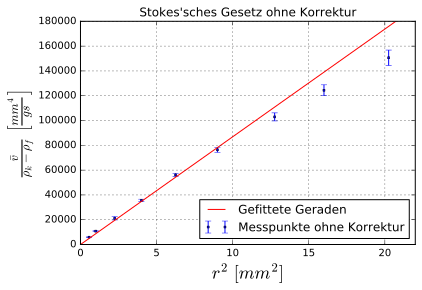

In [3]:
figure()
errorbar(rsq, y, yerr=dy, fmt='s', markersize=2.0, label='Messpunkte ohne Korrektur')
plot(arange(0,25,0.1), g(arange(0,25,0.1), m), 'r-', label='Gefittete Geraden')
xlim(0, 22)
ylim(0, 180000)
xlabel(r'$r^2 \ [mm^2]$', fontsize=18)
ylabel(r'$\frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$', fontsize=18)
title("Stokes'sches Gesetz ohne Korrektur")
grid()
legend(loc=4)
# savefig('',dpi=1000)
show()

In [4]:
R = 75/2
l = 1 + 2.1 * (data['Kugeldurchmesser']/2)/R

y_ = y * l

rs, drs = sm.symbols('r dr')
f_ = vs/(r_ks - r_fs) * (1 + 2.1 * rs/R)
f_abs_, f_rel_ = fehler.fehler(f_, vs, r_fs, r_ks, rs)

dy_ = array([f_abs_.subs([(vs, vm[i]), (r_fs, r_f), (r_ks, data['Dichte'][i]), (rs, data['Kugeldurchmesser'][i]/2),
                          (dvs, dvm[i]), (dr_fs, dr_f), (dr_ks, dr_k),
                          (drs, data['Kugeldurchmesser'][i]*0.01)]) for i in range(9)], dtype=float)

m_ = o.curve_fit(g, rsq, y_, sigma=dy_)
dm_ = sqrt(m_[1][0][0])
m_ = m_[0][0]
display(Math('m\'={0} \pm {1}'.format(m_, dm_)))


<IPython.core.display.Math object>

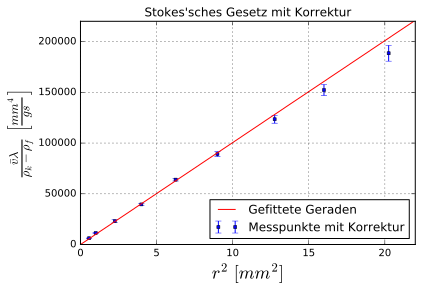

In [5]:
figure()
errorbar(rsq, y_, yerr=dy_, fmt='s', markersize=3.0, label='Messpunkte mit Korrektur')
plot(arange(0,25,0.1), g(arange(0,25,0.1), m_), 'r-', label='Gefittete Geraden')
xlim(0, 22)
ylim(0, 220000)
xlabel(r'$r^2 \ [mm^2]$', fontsize=18)
ylabel(r'$\frac{{\bar{{v}} \lambda}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$', fontsize=18)
title("Stokes'sches Gesetz mit Korrektur")
grid()
legend(loc=4)
show()

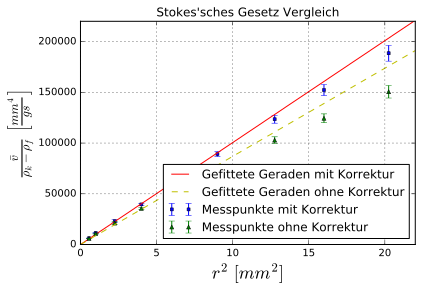

In [6]:
figure()

errorbar(rsq, y_, yerr=dy_, fmt='bs', markersize=3.0, label='Messpunkte mit Korrektur')
plot(arange(0,25,0.1), g(arange(0,25,0.1), m_), 'r-', label='Gefittete Geraden mit Korrektur')

errorbar(rsq, y, yerr=dy, fmt='g^', markersize=4.0, label='Messpunkte ohne Korrektur')
plot(arange(0,25,0.1), g(arange(0,25,0.1), m), 'y--', label='Gefittete Geraden ohne Korrektur')

xlim(0, 22)
ylim(0, 220000)
xlabel(r'$r^2 \ [mm^2]$', fontsize=18)
ylabel(r'$\frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$', fontsize=18)
title("Stokes'sches Gesetz Vergleich")
grid()
legend(loc=4)
show()

In [7]:
g_ = 9.80984 * 1000
n = 2/9 * g_ / m_
dn = n * dm_/m_
display(Latex(r'$\eta = {0} \pm {1} $'.format(n, dn)))

v_lam = m_ * (data['Dichte'] - r_f) * rsq
dv_lam = v_lam * sqrt((dm_/m_)**2 + (dr_k/(data['Dichte'] - r_f))**2 + (dr_f/(data['Dichte'] - r_f))**2 + (2*0.01)**2)

h = vm/v_lam
dh = h * sqrt((dvm/vm)**2 + (dv_lam/v_lam)**2)

Rey = r_f * vm * data['Kugeldurchmesser']/n

<IPython.core.display.Latex object>

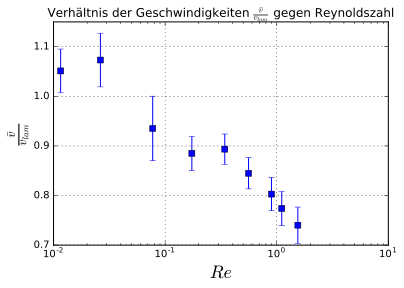

In [19]:
figure()
errorbar(Rey, h, yerr=dh, fmt='bs')
grid()
xscale('log')
xlabel('$Re$', fontsize=18)
ylabel(r'$\frac{{\bar{{v}}}}{{v_{{lam}}}}$', fontsize=18)
xlim(10**(-2),10)
title(r'Verhältnis der Geschwindigkeiten $\frac{{\bar{{v}}}}{{v_{{lam}}}}$ gegen Reynoldszahl')
show()

In [9]:
pt_vm = pd.DataFrame(data=[data['Kugeldurchmesser'], 
                           pd.Series(vm, name=r'$\bar{{v}} \ \left[ \frac{{mm}}{{s}} \right]$'),
                           pd.Series(dvm, name=r'$\Delta \bar{{v}}$')
                          ]).round(3)
display(pt_vm)

,0,1,2,3,4,5,6,7,8
Kugeldurchmesser,9.000,8.000,7.144,6.000,5.000,4.000,3.000,2.000,1.500
$\bar{{v}} \ \left[ \frac{{mm}}{{s}} \right]$,32.514,26.240,23.764,17.637,12.954,8.213,4.881,2.489,1.461
$\Delta \bar{{v}}$,1.286,0.866,0.707,0.408,0.233,0.213,0.308,0.103,0.045


In [10]:
pt_y = pd.DataFrame(data=[data['Kugeldurchmesser'],
                    pd.Series(y, name=r'$\frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$'),
                    pd.Series(dy, name=r'$\Delta \frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$'),
                    pd.Series(y_, name=r'$\frac{{\bar{{v}}\lambda}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$'),
                    pd.Series(dy_, name=r'$\Delta \frac{{\bar{{v}}\lambda}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$')
                    ]).round(0)
display(pt_y)

,0,1,2,3,4,5,6,7,8
Kugeldurchmesser,9,8,7,6,5,4,3,2,2
$\frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$,150597,124420,102918,76385,56104,35568,21141,10782,5941
$\Delta \frac{{\bar{{v}}}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$,6208,4366,3259,1954,1180,998,1354,460,191
$\frac{{\bar{{v}}\lambda}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$,188547,152290,123505,89218,63959,39552,22917,11385,6190
$\Delta \frac{{\bar{{v}}\lambda}}{{\rho_k-\rho_f}} \ \left[\frac{{mm^4}}{{gs}}\right]$,7809,5373,3932,2296,1354,1113,1468,486,200


In [11]:
pt_vlam = pd.DataFrame(data=[data['Kugeldurchmesser'], 
                           pd.Series(vm, name=r'$\bar{{v}} \ \left[ \frac{{mm}}{{s}} \right]$'),
                           pd.Series(dvm, name=r'$\Delta \bar{{v}}$'),
                            pd.Series(v_lam, name=r'$v_{{lam}} \ \left[ \frac{{mm}}{{s}} \right]$'),
                           pd.Series(dv_lam, name=r'$\Delta v_{{lam}}$')
                          ]).round(3)
display(pt_vlam)

,0,1,2,3,4,5,6,7,8
Kugeldurchmesser,9.000,8.000,7.144,6.000,5.000,4.000,3.000,2.000,1.500
$\bar{{v}} \ \left[ \frac{{mm}}{{s}} \right]$,32.514,26.240,23.764,17.637,12.954,8.213,4.881,2.489,1.461
$\Delta \bar{{v}}$,1.286,0.866,0.707,0.408,0.233,0.213,0.308,0.103,0.045
$v_{{lam}} \ \left[ \frac{{mm}}{{s}} \right]$,43.923,33.901,29.598,20.878,14.498,9.279,5.219,2.320,1.390
$\Delta v_{{lam}}$,1.289,0.999,0.860,0.607,0.421,0.270,0.152,0.067,0.040


In [12]:
pt_re = pd.DataFrame(data=[data['Kugeldurchmesser'],
                           pd.Series(h, name=r'$\frac{{\bar{{v}}}}{{v_{{lam}}}}$'),
                           pd.Series(Rey, name='$Re$')
                          ]).round(3)
display(pt_re)

,0,1,2,3,4,5,6,7,8
Kugeldurchmesser,9.000,8.000,7.144,6.000,5.000,4.000,3.000,2.000,1.500
$\frac{{\bar{{v}}}}{{v_{{lam}}}}$,0.740,0.774,0.803,0.845,0.894,0.885,0.935,1.073,1.051
$Re$,1.546,1.109,0.897,0.559,0.342,0.174,0.077,0.026,0.012
